# Hello PyTorch Convolutional Neural Networks

This notebook introduces the notion of Convolution in images and provides a **hello world** example for convoluational neural networks.



In [32]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time as t
import cv2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Image filters
### Sobel
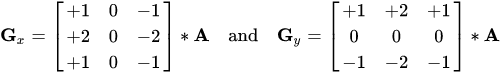


In [43]:
input_file = "../Data/2D/cnn_sobel.png"

## ------- Reading Images data ------
# Read images
im = np.array(Image.open(input_file))[:,:,0]
# Normalize for values between -1 and 1
scaler = MinMaxScaler()
scaler.fit(im)
im = scaler.transform(im)*4 - 2

(603, 531)


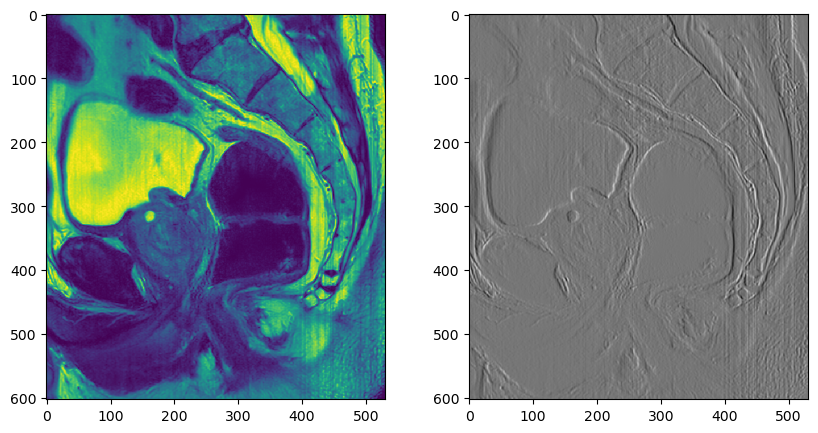

In [45]:
# Define sobel kernels
sob_filter_x = np.array([[1,0,-1],
                       [2,0,-2],
                       [1,0,-1]])

sob_filter_y = np.array([[1,2,1],
                         [0,0,0],
                         [-1,-2,-1]])

# Compute convolution for each kernel
sobel_x = cv2.filter2D(src=im, ddepth=-1, kernel=sob_filter_x)
sobel_y = cv2.filter2D(src=im, ddepth=-1, kernel=sob_filter_y)

# Plot
fig, axs = plt.subplots(1,2, figsize=(10,5))
print(im.shape)
axs[0].imshow(im)
axs[1].imshow(sobel_x, cmap='gray')
# axs[1].imshow(np.abs(sobel_x + sobel_y), cmap='gray')

1. Generate some synthetic data

In [46]:
# Create some synthetic data
## Create syntethic data
examples = 10000 # Total amount of examples
grid_size = 32 # Grid size 32x32
data = np.zeros((examples, grid_size, grid_size))
x = np.linspace(0, 4*np.pi, grid_size)
xx, yy = np.meshgrid(x,x)

X = np.array([np.sin(xx+np.random.rand(1)*grid_size) + np.sin(yy+np.random.rand(1)*grid_size) + .2*np.random.rand(grid_size) for i in range(examples)])
Y = np.array([cv2.filter2D(src=x, ddepth=-1, kernel=sob_filter_x) for x in X])
# Y = np.array([np.abs(cv2.filter2D(src=x, ddepth=-1, kernel=sob_filter_y) + cv2.filter2D(src=x, ddepth=-1, kernel=sob_filter_x)) for x in X])

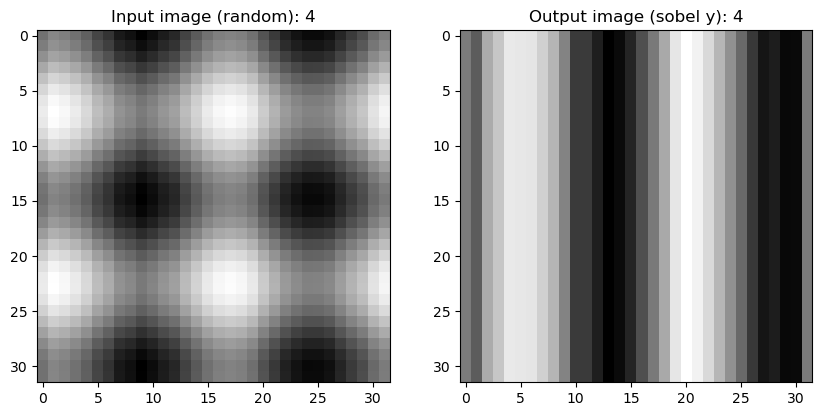

In [47]:
print(Y.shape)

fig, axs = plt.subplots(1,2, figsize=(10,5))
for i in range(5):
    axs[0].cla()
    axs[1].cla()
    display.clear_output(wait =True)
    axs[0].imshow(X[i,:,:], cmap='gray')
    axs[0].set_title(f'Input image (random): {i}')
    axs[1].imshow(Y[i,:,:],cmap='gray')
    axs[1].set_title(f'Output image (sobel y): {i}')
    plt.draw()
    t.sleep(1)
    display.display(plt.gcf())
display.clear_output(wait =True)

Single CNN layer model
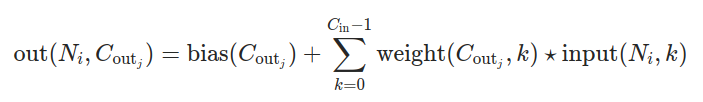


Total number of parameters:  10


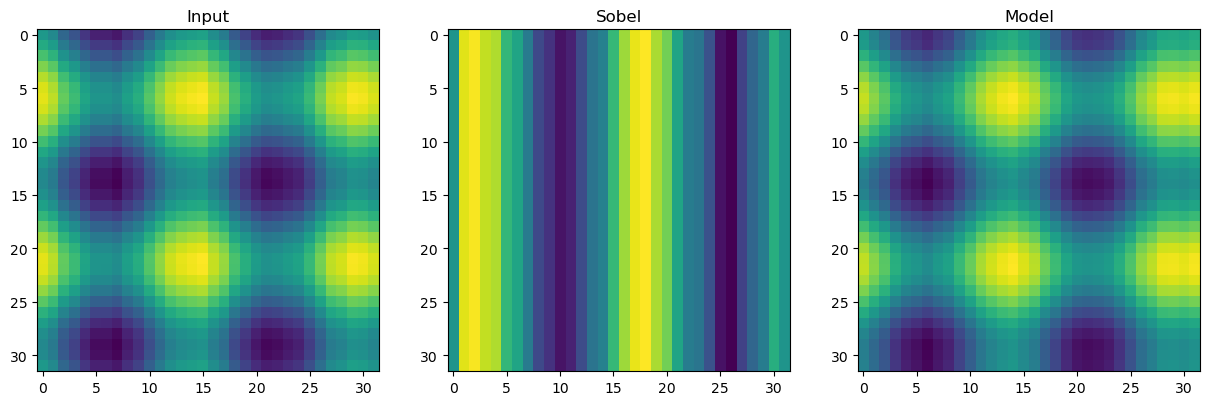

In [48]:
# Models are created by classes that inherit from Module
class SingleCNNModel(nn.Module):
    # On the init function we define our model
    def __init__(self):
        super().__init__() # Constructor of parent class
        # --------- Pure Sobel
        self.conv1 =  nn.Conv2d(1, 1, 3, padding="same", padding_mode='reflect')
        # --------- Composite Sobel
        # self.hidden_filters = 8
        # self.n_hidden_cnn = 1
        # self.conv1 =  nn.Conv2d(1, self.hidden_filters, 3, padding="same", padding_mode='reflect')
        # self.convlayers=  nn.ModuleList([nn.Conv2d(self.hidden_filters, self.hidden_filters, 3, padding="same", padding_mode='reflect') for x in range(self.n_hidden_cnn)])
        # self.conv2 =  nn.Conv2d(self.hidden_filters, 1, 3, padding="same", padding_mode='reflect')
        # self.relu = nn.ReLU()
    
    # On the forward function we indicate how to make one 'pass' of the model
    def forward(self, x):
        # ---------- Pure Sobel
        l1 = self.conv1(x)
        # --------- Composite Sobel
        # for i in range(self.n_hidden_cnn):
        #     l1 = nn.functional.relu(self.convlayers[i](l1))  # With batch normalization
        # l1 = self.conv2(l1)
        return l1

    
ex_model = SingleCNNModel().to(device)
# print(list(ex_model.named_parameters()))
print("Total number of parameters: ", sum(p.numel() for p in ex_model.parameters() if p.requires_grad))

# Reshape to the proper input of the network
X_torch = torch.reshape(torch.tensor(X), (X.shape[0], 1, X.shape[1], X.shape[2])).to(device, dtype=torch.float)
Y_torch = torch.reshape(torch.tensor(Y), (Y.shape[0], 1, Y.shape[1], Y.shape[2])).to(device, dtype=torch.float)

model_y = ex_model(X_torch).cpu().detach().numpy()
#-------------- Just for plotting --------------
fig, ax = plt.subplots(1,3, figsize=(15,5))
def plotCurrentModel(x, y, model, ax):
    # Torch receives inputs with shape [Examples, input_size]
    ax[0].imshow(x)
    ax[0].set_title('Input')
    ax[1].imshow(y)
    ax[1].set_title('Sobel')
    im = ax[2].imshow(model)
    ax[2].set_title('Model')
    
ex = 0
plotCurrentModel(X[ex,:,:], Y[ex,:,:], model_y[ex,0,:,:], ax)

3.Optimize the parameters of the model using backpropagation 

In [49]:
loss_mse = nn.MSELoss() # Define loss function
# optimizer = torch.optim.SGD(ex_model.parameters(), lr=8e-3) # Define optimization algorithm
optimizer = torch.optim.Adam(ex_model.parameters(), lr=3e-3) # Define optimization algorithm

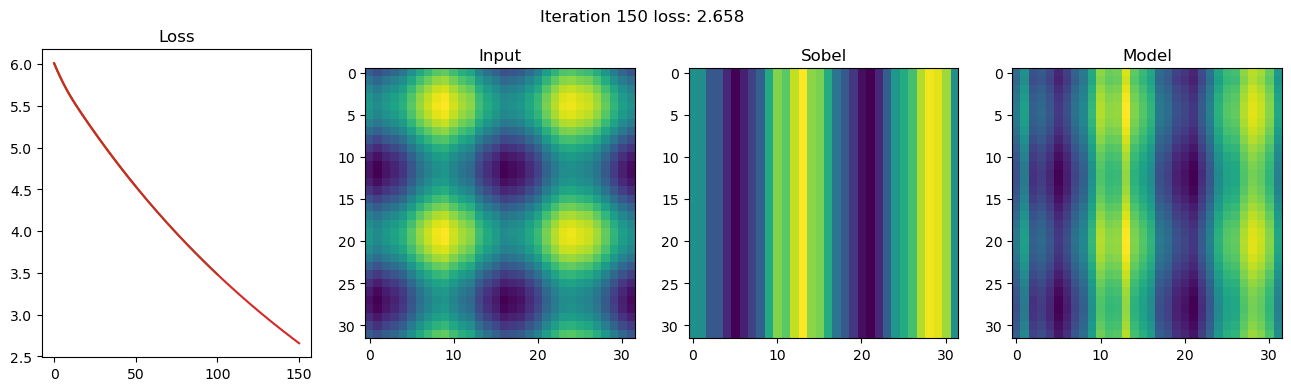

In [ ]:
# Optimize the parameters several times

fig, ax = plt.subplots(1,4, figsize=(16,4))
ex_model.train()
loss_history = []
for i in range(800):
    pred = ex_model(X_torch)
    loss = loss_mse(pred, Y_torch)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.detach().to('cpu'))
    
    # ---------- Just for plotting ---------
    if i % 50 == 0: 
        title = f"Iteration number {i} loss: {loss:0.3f}"
        display.clear_output(wait =True)
        ex = np.random.randint(0,1000,1)[0]
        model_y = ex_model(X_torch).cpu().detach().numpy()
        ax[0].plot(range(i+1), loss_history)
        ax[0].set_title('Loss')
        ax[1].imshow(X[ex,:,:])
        ax[1].set_title('Input')
        ax[2].imshow(Y[ex,:,:])
        ax[2].set_title('Sobel')
        ax[3].imshow(model_y[ex,0,:,:])
        ax[3].set_title('Model')
        plt.suptitle(f'Iteration {i} loss: {loss:.3f}')
        plt.draw()
        t.sleep(0.1)
        display.display(plt.gcf())
    
display.clear_output(wait =True)
print("Done!")

In [ ]:
print(list(ex_model.named_parameters()))

## Using the model 
### Sobel
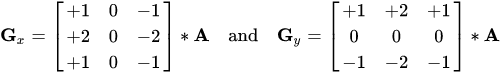


In [ ]:
# We transform the input as tensor and reshape with 'batch 1'
X_torch = torch.reshape(torch.tensor(im), (1, 1, im.shape[0], im.shape[1])).to(device, dtype=torch.float)
model_y = ex_model(X_torch).cpu().detach().numpy()


In [ ]:
Y_true = cv2.filter2D(src=im, ddepth=-1, kernel=sob_filter_x)
# Y_true = np.abs(cv2.filter2D(src=im, ddepth=-1, kernel=sob_filter_y) + cv2.filter2D(src=im, ddepth=-1, kernel=sob_filter_x))

fig, axs = plt.subplots(1,3, figsize=(21,7))
axs[0].imshow(im)
axs[1].imshow(model_y[0,0,:,:],'gray')
axs[1].set_title("Model")
axs[2].imshow(Y_true,'gray')
axs[2].set_title("True Sobel")
plt.show()
model_y.shape